In [ ]:
# ===============================
# STEP 0: Install required packages
# ===============================
!pip install scikit-learn nltk tensorflow --quiet

# ===============================
# STEP 1: Upload CSV file from desktop
# ===============================
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

filename = next(iter(uploaded))
# Safe fallback for non-UTF-8 files
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='ISO-8859-1')

print(df.head())
print("Available columns:", df.columns)

# Rename columns if necessary
df['label'] = df['v1']
df['text'] = df['v2']


# ===============================
# STEP 2: Import libraries
# ===============================
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords



Saving spam.csv to spam.csv
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
Available columns: Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ===============================
# STEP 3: Preprocess text column
# ===============================
#  Make sure your dataset has columns named 'text' and 'label'
def preprocess_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
# ===============================
# STEP 4: Feature extraction with Bag of Words
# ===============================
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['clean_text'])

# Target labels
y = df['label']

In [ ]:
# ===============================
# STEP 5: Split data into train/test
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [ ]:
# ===============================
# STEP 6: Train 3 Machine Learning models
# ===============================
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'SVM': SVC()
}

print("\n=== Machine Learning Models Evaluation ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))


=== Machine Learning Models Evaluation ===

Naive Bayes
Accuracy: 0.968609865470852
F1 Score: 0.968910601123947
Recall: 0.968609865470852

Logistic Regression
Accuracy: 0.9766816143497757
F1 Score: 0.9757302466310818
Recall: 0.9766816143497757

SVM
Accuracy: 0.9739910313901345
F1 Score: 0.9728842916274031
Recall: 0.9739910313901345


In [ ]:
# ===============================
# STEP 7: Prepare for LSTM model
# ===============================
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
X_pad = pad_sequences(X_seq, maxlen=100)

# Convert string labels to binary (0 and 1)
# First check what your label values are
print("Unique labels:", df['label'].unique())
y_numeric = np.where(df['label'] == 'spam', 1, 0)  # Adjust based on your actual labels

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Train/test split for deep learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_numeric, test_size=0.2, random_state=42
)

Unique labels: ['ham' 'spam']


In [ ]:
# ===============================
# STEP 8: Define and train LSTM model
# ===============================
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_dl,  # No need for np.array() as it's already a numpy array
    y_train_dl,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_dl, y_test_dl)
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.8849 - loss: 0.3231 - val_accuracy: 0.9812 - val_loss: 0.0722
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9858 - loss: 0.0430 - val_accuracy: 0.9839 - val_loss: 0.0562
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9979 - loss: 0.0108 - val_accuracy: 0.9803 - val_loss: 0.0616
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9704 - val_loss: 0.0955
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9767 - val_loss: 0.0856


In [ ]:
# ===============================
# STEP 9: Evaluate LSTM model
# ===============================
y_pred_dl = model.predict(X_test_dl)
y_pred_classes = (y_pred_dl > 0.5).astype(int)

print("\n=== LSTM Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test_dl, y_pred_classes))
print("F1 Score:", f1_score(y_test_dl, y_pred_classes))
print("Recall:", recall_score(y_test_dl, y_pred_classes))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

=== LSTM Model Evaluation ===
Accuracy: 0.9766816143497757
F1 Score: 0.9133333333333333
Recall: 0.9133333333333333


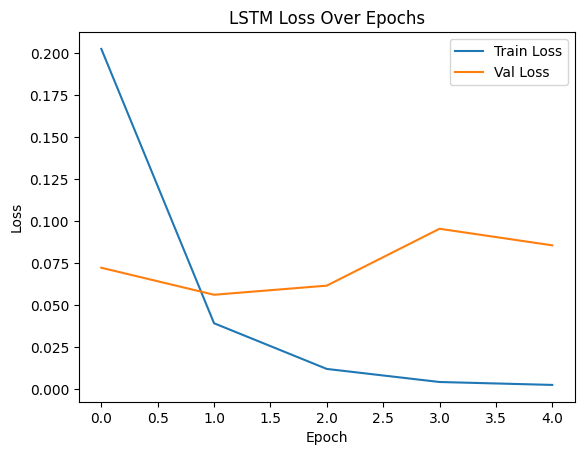

In [ ]:
# ===============================
# STEP 10: Plot training and validation loss
# ===============================
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()